## 2020 Belden Price Optimization Project
## SVM Modeling
**Package Importing**

In [0]:
# Install scikit learn 0.21.2 to ensure download and read models
!pip install scikit-learn==0.21.2
%pylab inline

# Import basic python packages
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams

# Import machine learning packages 
import sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib 

# Print sklearn version
print('The scikit-learn version is {}.'.format(sklearn.__version__))

     |████████████████████████████████| 6.7MB 2.7MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
Populating the interactive namespace from numpy and matplotlib
The scikit-learn version is 0.21.2.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
# Mount google drive (Not need this when running locally)
from google.colab import drive
drive.mount('/content/drive')

## INCA Product
**Data Filtering**

In [0]:
# Read Original INCA data"
df_INCA=pd.read_csv('INCA.csv').drop(['Unnamed: 0'],axis=1)

In [0]:
# Drop items which have 0 costs or prices
df_INCA=df_INCA.loc[(df_INCA['Quoted Cost (FT)']!=0)&(df_INCA['Quoted Price (FT)']!=0)].reset_index(drop=True)

In [0]:
# Drop items which have never been sold
df_drop=df_INCA.groupby(by='Item Number').agg({"accept": "sum"}).reset_index()
df_INCA=df_INCA.loc[df_INCA['Item Number'].isin(list(df_drop.loc[df_drop['accept']>0]['Item Number']))]

# Drop customers who have never bought anything
df_cus=df_INCA.groupby(by='Customer Number').agg({'accept':'sum'}).reset_index()
df_INCA=df_INCA.loc[df_INCA['Customer Number'].isin(list(df_cus.loc[df_cus['accept']>0]['Customer Number']))]

# Drop end-user projects which have never been a deal
df_end=df_INCA.groupby(by='End User Project').agg({'accept':'sum'}).reset_index()
df_INCA=df_INCA.loc[df_INCA['End User Project'].isin(list(df_end.loc[df_end['accept']>0]['End User Project']))]

In [0]:
# Calculate relative price group by product code
df_meanproduct=df_INCA.groupby(by='Product Code').agg({'Quore Price (Modifed)':'mean'})
df_INCA=pd.merge(df_INCA,df_meanproduct,how='left',on='Product Code')
df_INCA['relative_price']=df_INCA['Quore Price (Modifed)_x']-df_INCA['Quore Price (Modifed)_y']

In [0]:
# See the finished general table
df_INCA.head(5)

,Unnamed: 0.1,Item Number,mean_cost,mean_price,Quote Number,Product Code,Sales Incentive Recap Class 2,Verticalmarket,Divisionregion,Customer Number,Customer Name,End User Project,Estimator,Completed Date,Quoted Price (FT),Quoted Cost (FT),Quoted Quantity,accept,Copperprice,Copperprice_t-1,Copperprice_t-2,Copperprice_t-3,Copperprice_t-4,Copperprice_t-5,Copperweight,Quore Price (Modifed)_x,Quote Cost (Modified),margin,recapmargin,Quore Price (Modifed)_y,relative_price
0,1,8525 0101000,0.014300,0.111500,1280228,8525,Lead Wire Plastic Low Temp,ES - Retail,IND - Gulf Region,2872,ANIXTER ANAHEIM 051 122,CABLE CONNECTIONS,traci.collings@belden.com,2019-02-05,0.110,0.0143,32,1,2.8170,2.7950,2.7850,2.7850,2.77500,2.78900,0.001370,0.110,0.014300,6.692308,2.107747,0.111500,-0.001500
1,2,8456 060100,0.013000,0.098429,1312799,8456,Classics Low Temp,ES - Data Centers,IND - East Region,19136,HOUSTON W & C HOUSTON,Meridian Data Center,kali.culbertson@belden.com,2019-08-05,0.100,0.0130,2,0,2.5370,2.5510,2.5510,2.5650,2.66000,2.65800,0.019700,0.100,0.013000,6.692308,3.401935,0.577603,-0.477603
2,64,8325 060500,0.520800,0.004000,1320484,8325,Classics Low Temp,ES - Retail,IND - West Region,114552,WIREXPRESS-EK GR VIL 351/848,Simplyvast,Tanner.steele@belden.com,2019-09-26,0.004,0.5208,1,1,2.5600,2.5950,2.5895,2.5945,2.59225,2.59225,0.120880,0.004,0.000521,6.680492,3.401935,0.005500,-0.001500
3,80,8816,0.017891,0.095283,1311971,8816,Lead Wire Plastic Low Temp,ES - Government,IND - East Region,144945,ACCU TECH FEDERAL 520,Lockheed Martin BPA,Kate.robinson@belden.com,2019-07-30,0.139,0.0181,2,0,2.6705,2.7095,2.6930,2.6930,2.67650,2.69550,0.032343,0.139,0.018100,6.679558,2.107747,0.093932,0.045068
4,81,8816,0.017891,0.095283,1312142,8816,Lead Wire Plastic Low Temp,ES - Government,IND - West Region,34024,ALLIED ELECTRONICS,Lockheed Martin BPA,Tanner.steele@belden.com,2019-07-30,0.139,0.0181,2,0,2.6705,2.7095,2.6930,2.6930,2.67650,2.69550,0.032343,0.139,0.018100,6.679558,2.107747,0.093932,0.045068


In [0]:
# Generate input table
result=pd.concat([df_INCA['Item Number'],df_INCA['Product Code'],df_INCA['Completed Date'],df_INCA['Quore Price (Modifed)_x'],df_INCA['Quore Price (Modifed)_y'],df_INCA['accept'],df_INCA['Customer Number'],df_INCA['relative_price'],df_INCA['Quote Cost (Modified)'],pd.get_dummies(df_INCA['Sales Incentive Recap Class 2'])\
   ,pd.get_dummies(df_INCA['Divisionregion']),pd.get_dummies(df_INCA['End User Project']),pd.get_dummies(df_INCA['Item Number']),df_INCA['Quoted Quantity']],axis=1).dropna()

In [0]:
# See the input table
result.head(5)

,Item Number,Product Code,Completed Date,Quore Price (Modifed)_x,Quore Price (Modifed)_y,accept,Customer Number,relative_price,Quote Cost (Modified),Basics VFD Cu Tape,Blue Hose,Classics High Temp,Classics Low Temp,ControlNet,DeviceNet,Foundation FieldBus,Industrial Ethernet Cable Cat 5e,Industrial Ethernet Cable Cat 6,Industrial Ethernet Connectivity,Lead Wire Plastic High Temp,Lead Wire Plastic Low Temp,Lead Wire Rubber,MIPP,MachFlex Moderate,MachFlex TC,Misc Networking,PROFIBUS,RS-485,Security Coax,Security MultiConductor,SpaceMaker,VFD Cu Tape,VFD Foil+Braid,IND - Central Region,IND - East Region,IND - Gulf Region,IND - West Region,1 Manhattan West,112 Shawmut Ave,116 John Street,...,AG57870 0101000,AG59796 0041000,E100601 010S1,E100623 000S1,E505001 010S1,E505002 010S1,E505005 010S1,E605001 010S1,E605002 010S1,E605004 010S1,E605009 010S1,E605013 010S1,E6050M3 010S1,E6051M5 010S1,EY60196 010005,EY6F201 006021,EY6F201 006053,EY6F201 006058,EY6F201 006073,EY6F201 010039,EY6F201 010048,EY6F201 010058,EY6F201 010063,EY6F201 010068,R301601 000S1,R301602 000S1,R301603 000S1,R301604 000S1,RV5IJ2SME-B24,RV6IJ2UBK-B24,RVAIP2SME-S1,RVAIP2UBK-B24,RVAIP2UBK-S1,RVUIO0UEW-B50,Y66004 0101000,Y66313 0101000,Y66341 0081000,Y66382 06010000,YM55426 0061000,Quoted Quantity
0,8525 0101000,8525,2019-02-05,0.110,0.111500,1,2872,-0.001500,0.014300,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32
1,8456 060100,8456,2019-08-05,0.100,0.577603,0,19136,-0.477603,0.013000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2,8325 060500,8325,2019-09-26,0.004,0.005500,1,114552,-0.001500,0.000521,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,8816,8816,2019-07-30,0.139,0.093932,0,144945,0.045068,0.018100,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,8816,8816,2019-07-30,0.139,0.093932,0,34024,0.045068,0.018100,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


In [0]:
# Format date information to prepare for validation
result['Completed Date']=pd.to_datetime(result['Completed Date'])

**SVM Modeling**

In [0]:
# Split training and testing data (8:2)
train_set, test_set = train_test_split(result, test_size = 0.2, random_state = 1)

train_set.reset_index(drop = True, inplace = True)
test_set.reset_index(drop = True, inplace = True)

x_training = train_set.copy().iloc[:,6:]
x_testing=test_set.copy().iloc[:,6:]
y_training=train_set.copy().iloc[:,5]
y_testing=test_set.copy().iloc[:,5]

In [0]:
# Fit the model (Usually take hours due to the size of the dataset)
clf = svm.SVC(probability=True,kernel='linear'，C=1.0, cache_size=200)
clf.fit(x_training, y_training)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
# Save the model as a pickle in a file for future use
joblib.dump(clf,'SVM_INCA_Model.pkl') 

['/content/drive/My Drive/Belden/Belden_SVM_Modified_Relative_price.pkl']

In [0]:
# Load the model
clf = joblib.load('SVM_INCA_Model.pkl')

**Grab useful information from the result**

In [0]:
# Output factor coefficient table, sort by descending coefficient
df_coef=pd.DataFrame({'Factor_name':x_training.columns,'Coefficient':clf.coef_[0]}).sort_values(by='Coefficient',ascending=False)
df_coef.head(5)

,Factor_name,Coefficient
6,Classics Low Temp,1401.048820
28,IND - East Region,1170.334294
2,Quote Cost (Modified),914.036178
30,IND - West Region,614.000000
1,relative_price,465.154143


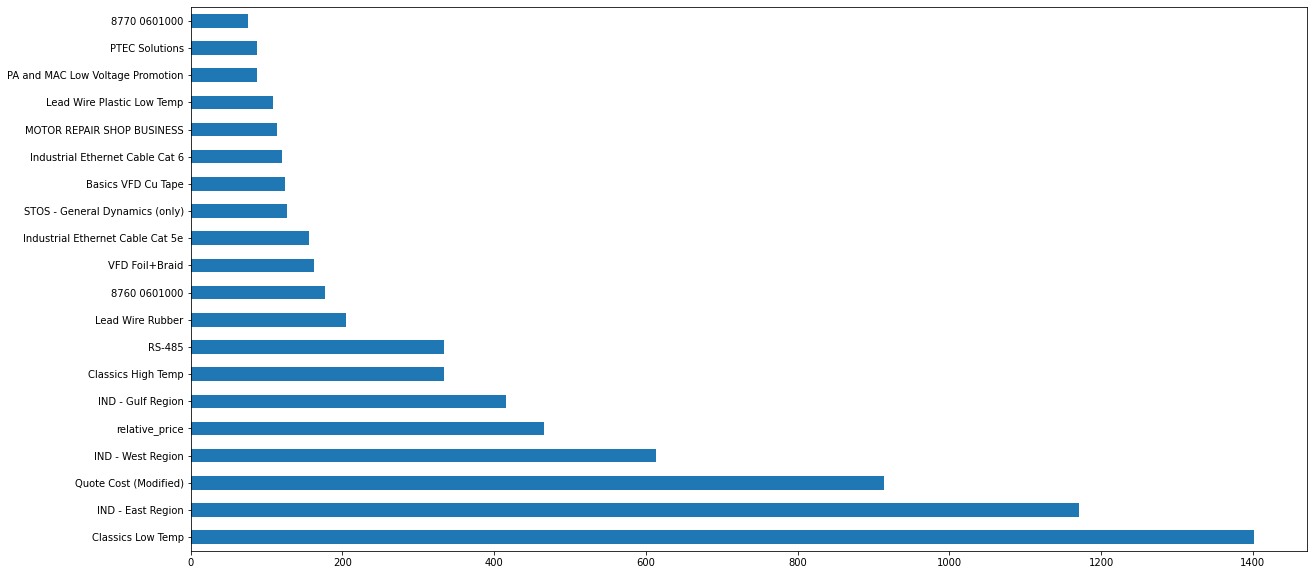

In [0]:
# Output top 20 positive coefficient
pd.Series(clf.coef_[0], index=x_training.columns).nlargest(20).plot(kind='barh',figsize=(20,10))

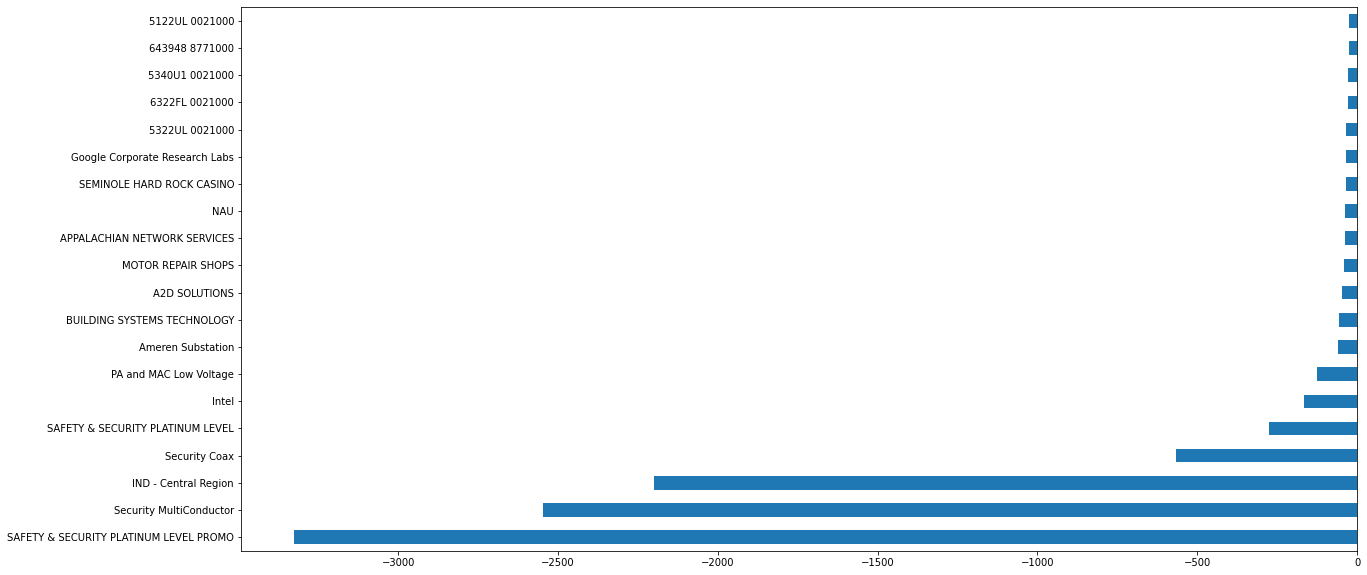

In [0]:
# Output top 20 negative coefficient
pd.Series(clf.coef_[0], index=x_training.columns).nsmallest(20).plot(kind='barh',figsize=(20,10))

**Model Validation**

In [0]:
# Use records from Novemenber to December for validating
df_test=result.loc[result['Completed Date']>='2019-11-1']
x_testing=df_test.iloc[:,6:]
y_testing=df_test.iloc[:,5]

In [0]:
# Predict test data
y_probability=clf.predict_proba(x_testing)
y_pred=clf.predict(x_testing)

In [0]:
# Create a list to contain the probability of accepting for each quote
one_probability=[]
for i in range(len(y_probability)):
  one_probability.append(y_probability[i][1])

# Format the final result table
df_forecast=pd.DataFrame({'Actual':y_testing,'Predicted':y_pred,'1_probability':one_probability,'price':df_test['Quore Price (Modifed)_x'],'cost':x_testing['Quote Cost (Modified)'],'quantity':x_testing['Quoted Quantity']})

# Caclculate the forecasting error
df_forecast['error']=df_forecast['Actual']-df_forecast['Predicted']

# Calculate the margin for each quote
df_forecast['profit']=(df_forecast['price']-df_forecast['cost'])*df_forecast['quantity']
df_forecast['profit']=df_forecast['profit'].apply(lambda x:0 if x<0 else x)

# Calculate the expected profit, actual profit, predicted profit for each quote
df_forecast['expected_profit']=df_forecast['1_probability']*df_forecast['profit']
df_forecast['Actual_profit']=df_forecast['Actual']*df_forecast['profit']
df_forecast['Predicted_profit']=df_forecast['Predicted']*df_forecast['profit']

# See the finished forecasting result table
df_forecast.head(5)

,Actual,Predicted,1_probability,price,cost,quantity,error,profit,expected_profit,Actual_profit,Predicted_profit
7,0,0,0.168992,0.132,0.0172,50,0,5.7400,0.970012,0.0,0.0
10,0,0,0.168992,0.132,0.0172,50,0,5.7400,0.970012,0.0,0.0
11,0,0,0.168992,0.132,0.0172,50,0,5.7400,0.970012,0.0,0.0
13,0,0,0.168992,0.132,0.0172,50,0,5.7400,0.970012,0.0,0.0
18,0,0,0.183414,0.105,0.0137,1,0,0.0913,0.016746,0.0,0.0


In [0]:
#Output Acceptance accuracy
print('The acceptance accuracy is ',df_forecast[df_forecast['error']==0].shape[0]/df_forecast.shape[0])

The acceptance accuracy is  0.8901167121926993


In [0]:
#Output total expected profit
print('Total actual profit is ',df_forecast.Actual_profit.sum())
print('Total predicted profit is  ',df_forecast.expected_profit.sum())

Total actual profit is  634887.749999
Total predicted profit is   660980.0581648925


**Price Optimization**

In [0]:
# Generate an input table contained all the information needed for the results
result2=pd.concat([df_INCA['Item Number'],df_INCA['Estimator'],df_INCA['Divisionregion'],df_INCA['Verticalmarket'],df_INCA['Product Code'],df_INCA['Completed Date'],df_INCA['Quore Price (Modifed)_x'],df_INCA['Quore Price (Modifed)_y'],df_INCA['accept'],df_INCA['Customer Number'],df_INCA['relative_price'],df_INCA['Quote Cost (Modified)'],pd.get_dummies(df_INCA['Sales Incentive Recap Class 2'])\
   ,pd.get_dummies(df_INCA['Divisionregion']),pd.get_dummies(df_INCA['End User Project']),pd.get_dummies(df_INCA['Item Number']),df_INCA['Quoted Quantity']],axis=1).dropna()

In [0]:
# Select an item and offer a list of prices
Item_Number='EY60196 010005'

In [0]:
# Define function that return the expected profit of the quote
def calculated_profit(df_input):
  y_pred=clf.predict(df_input)
  y_probability=clf.predict_proba(df_input)

  # Create a list to contain the probability of accepting for each quote
  one_probability=[]
  zero_probability=[]
  for i in range(len(y_probability)):
    one_probability.append(y_probability[i][1])
    zero_probability.append(y_probability[i][0])

  # Format the final result table
  df_forecast=pd.DataFrame({'Predicted':y_pred,'1_probability':one_probability,'0_probability':zero_probability,'price':df_row['Quore Price (Modifed)_x'],'cost':df_row['Quote Cost (Modified)'],'quantity':df_row['Quoted Quantity']})

  # Calculate the margin for each quote
  df_forecast['profit']=df_forecast['price']-df_forecast['cost']
  
  df_forecast['profit']=df_forecast['profit'].apply(lambda x:0 if x<0 else x)

  # Calculate the expected profit for each quote
  df_forecast['expected_profit']=df_forecast['1_probability']*df_forecast['profit']
  result=[df_forecast.expected_profit.sum(),list(df_forecast['0_probability'])[0],list(df_forecast['1_probability'])[0]]
  return result

In [0]:
#Set upper and lower limit for price ranges
Upper=1.6
Lower=0.8

In [0]:
# Extract the item information from the general table
df_5000=result2.groupby(by='Item Number').get_group(Item_Number)

# Create a list to contain all the item prices
Item_Price=[]

# Create a list to contain all the item profit
Item_Profit=[]

# Create a list to find the maximum profit
Result_set=[]

# Create a list to contain all the item reject probability
zeroprobability=[]

# Create a list to contain all the item accept probability
oneprobability=[]

zero=[]
one=[]
for i in range(df_5000.shape[0]):
  df_row=df_5000.copy().iloc[i:i+1,:]
# Create a price list that generates a list of prices from 0.8*price to 1.6*price
  Price_list=list(np.arange(list(df_row['Quore Price (Modifed)_x'])[0]*Lower,list(df_row['Quore Price (Modifed)_x'])[0]*Upper,(list(df_row['Quore Price (Modifed)_x'])[0]*Upper-list(df_row['Quore Price (Modifed)_x'])[0]*Lower)/10)) 
  for j in Price_list:
# Replace item price with the selected new price
    df_row['Quore Price (Modifed)_x']=j
# Calculate the new relative price
    df_row['relative_price']=df_row['Quore Price (Modifed)_x']-df_row['Quore Price (Modifed)_y']
    df_input=df_row.iloc[:,9:].reset_index(drop=True)
# Calculate new expected profit
    L=calculated_profit(df_input)
    Result_set.append(L[0])
    zeroprobability.append(L[1])
    oneprobability.append(L[2])
# Find the maximum profit
  Item_Profit.append(max(Result_set))
# Get the according price that maximizes the profit
  Item_Price.append(Price_list[Result_set.index(max(Result_set))])
  zero.append(zeroprobability[Result_set.index(max(Result_set))])
  one.append(oneprobability[Result_set.index(max(Result_set))])
  Result_set=[]
  zeroprobability=[]
  oneprobability=[]

In [0]:
# Create new columns with results
df_5000['Suggeted Price']=Item_Price
df_5000['Optimal Profit']=Item_Profit
df_5000['1_probability']=one
df_5000['0_probability']=zero

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [0]:
# Create new tabke contain new results
df_adjusted_5000=pd.concat([df_5000['Item Number'],df_5000['Estimator'],df_5000['Divisionregion'],df_5000['Verticalmarket'],df_5000['Customer Number'],df_5000['Quote Cost (Modified)'],\
                                     df_5000['Quore Price (Modifed)_x'],df_5000['Suggeted Price'],df_5000['accept'],df_5000['Quoted Quantity'],df_5000['1_probability'],df_5000['0_probability']],axis=1).dropna()
df_adjusted_5000=df_adjusted_5000.rename({'Quore Price (Modifed)_x':'Original Price'},axis=1).reset_index(drop=True)

In [0]:
# See the final results table
df_adjusted_5000.head(5)

,Item Number,Estimator,Divisionregion,Verticalmarket,Customer Number,Quote Cost (Modified),Original Price,Suggeted Price,accept,Quoted Quantity,1_probability,0_probability
0,EY60196 010005,greg.adams@belden.com,IND - Central Region,IND - Discrete,147359,0.004922,0.013,0.01976,0,4,0.186774,0.813226
1,EY60196 010005,Kate.robinson@belden.com,IND - East Region,ES - Retail,91312,0.004922,0.012,0.01824,1,150,0.179502,0.820498
2,EY60196 010005,Kate.robinson@belden.com,IND - East Region,ES - Retail,91312,0.004922,0.012,0.01824,0,1,0.179507,0.820493
3,EY60196 010005,Kate.robinson@belden.com,IND - East Region,ES - Retail,91312,0.004922,0.012,0.01824,0,1,0.179507,0.820493
4,EY60196 010005,Kate.robinson@belden.com,IND - East Region,ES - Retail,91312,0.004922,0.012,0.01824,0,1,0.179507,0.820493


In [0]:
# Save the optimization results as local file
df_adjusted_5000.to_csv('optimization.csv')

In [0]:
# Read the optimization results
df_opt=pd.read_csv('optimization.csv').drop(['Unnamed: 0'],axis=1)

In [0]:
# Split the results in half to release computing pressure
df_opt['likelyhood']=df_opt['accept']
df_opt1=df_opt.iloc[:int(df_opt.shape[0]/2),:]
df_opt2=df_opt.iloc[int(df_opt.shape[0]/2):,:]

In [0]:
# Calculate the loglikelyhood
df_opt1['likelyhood']=df_opt1['accept'].apply(lambda x: df_opt1['1_probability'] if x==1 else df_opt1['0_probability'])
df_opt1['loglikelyhood']=np.log(df_opt1['likelyhood'])
df_opt2['likelyhood']=df_opt2['accept'].apply(lambda x: df_opt2['1_probability'] if x==1 else df_opt2['0_probability'])
df_opt2['loglikelyhood']=np.log(df_opt2['likelyhood'])
df_opt=pd.concat([df_opt1,df_opt2])
df_opt['loglikelyhood'].sum()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

-9.572958029030362